# Comparaison of regression lines and analysis of covariance

## 1. Introduction

Previously, we discussed simple linear regression which involves fitting a straight line to a number of points using the method of least squares. In this chapter we show how to compare two or more regression lines. We also show how this technique can be used with analysis of variance to control experimental error, a method called analysis of covariance.

## 2. Comparison of two regression lines

Here we describe how to test whether regression lines fitted to two independent sets of data are parallel. Using the two independent estimates of slope $\hat{\beta_1}$, $\hat{\beta_2}$ based on $n_1$ and $n_2$ observations, you wish to test the hypothesis that $\hat{\beta_1} = \hat{\beta_2}$. If you can assume parallel lines you can go on to test whether the intercepts are equal. If they are you can fit an overall line to the data.

In our working example, a greenhouse experiment was carried out to investigate the response of strawberry to two types of fertiliser (F1 and F2). Four plants were grown in each pot and twelve pots were treated at random with each fertiliser. At harvest time various measurements were made on each pot, but for this example we are only interested in the total fruit dry weight (X) and the total leaf area (Y).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, f, probplot, linregress, levene

In [2]:
#dataframe of experimental data
data = pd.DataFrame({'fertiliser':[1 for _ in range(12)] + [2 for _ in range(12)],
                     'X':[0.29, 0.43, 0.21, 0.53, 0.27, 0.33, 0.47, 0.40, 0.48, 0.30, 0.37, 0.30,
                          0.27, 0.37, 0.42, 0.19, 0.30, 0.25, 0.35, 0.48, 0.22, 0.30, 0.14, 0.32],
                     'Y':[144, 180, 60, 226, 105, 111, 217, 221, 218, 137, 153, 105,
                          129, 206, 172, 80, 124, 89, 134, 220, 138, 105, 62, 181]})

### 2.1 Testing for equality of slopes

To test the hypothesis that $\hat{\beta_1} = \hat{\beta_2}$ carry out a t-test by calculating $t = (\hat{\beta}_1 - \hat{\beta}_2) \: / \: SED$ and calculate a p-value on $n_1 + n_2 - 4$ degrees of freedom where SED is the standard error of the difference between the two fitted slopes.

$$ SED = \sqrt{s_p^2 \left( \frac{1}{S_{xx1}} + \frac{1}{S_{xx2}} \right)} $$

$$ s_p^2 = \frac{ResidSS_1 + ResidSS_2}{(n_1 - 2) + (n_2 - 2)} $$

$s_p^2$ is an estimate of the assumed common population residual variance. When $n_1 = n_2$ this is the average of the two residual mean squares $RMS_1$ and $RMS_2$. To test the assumption of common population variance you divide the larger RMS by the smaller to obtain an F-value and then calculate a p-value on $n - 2$ degrees of freedom.

Testing the equality of slopes

t-value : 0.775
p-value : 0.22365


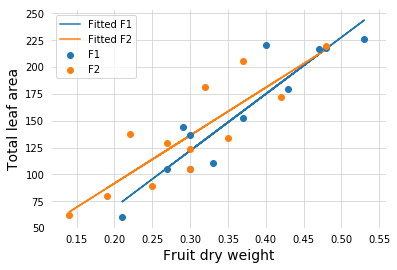

In [38]:
#get x and y values for the two treatments
X1 = data[data['fertiliser']==1]['X']
X2 = data[data['fertiliser']==2]['X']
Y1 = data[data['fertiliser']==1]['Y']
Y2 = data[data['fertiliser']==2]['Y']

#sample size
n1 = len(data[data['fertiliser']==1])
n2 = len(data[data['fertiliser']==2])

#degrees of freedom
df1 = n1 - 2
df2 = n2 - 2
df_resid = df1 + df2

#get sum of squares
Sxx1 = X1.var() * (n1 - 1)
Sxx2 = X2.var() * (n2 - 1)

#perform  linear regression
slope1, intercept1, rval1, pval1, stderr1 = linregress(X1, Y1)
slope2, intercept2, rval2, pval2, stderr2 = linregress(X2, Y2)

#fitted values
Y1_fit = X1 * slope1 + intercept1
Y2_fit = X2 * slope2 + intercept2

#residual sum of squares
resid_ss1 = np.sum((Y1 - Y1_fit) ** 2)
resid_ss2 = np.sum((Y2 - Y2_fit) ** 2)

#residual mean squares
resid_ms1 = resid_ss1 / df1
resid_ms2 = resid_ss2 / df2

#common population residual variance
sp2 = (resid_ss1 + resid_ss2) / (n1 + n2 - 4)

#standard error of the difference between the slopes
sed = np.sqrt(sp2 * (1 / Sxx1 + 1 / Sxx2))

t_val = (slope1 - slope2) / sed

p_val = 1 - t.cdf(abs(t_val), df_resid)

fig, ax = plt.subplots()
ax.scatter(X1, Y1, label='F1', zorder=5)
ax.scatter(X2, Y2, label='F2', zorder=5)
ax.plot(X1, X1 * slope1 + intercept1, label='Fitted F1', zorder=4)
ax.plot(X2, X2 * slope2 + intercept2, label='Fitted F2', zorder=4)
for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(False)
ax.grid(color='lightgrey')
ax.tick_params(axis='both', color='white')
ax.set_xlabel('Fruit dry weight', fontsize=14)
ax.set_ylabel('Total leaf area', fontsize=14)
plt.legend()

print('Testing the equality of slopes\n')
print('t-value : {:.3f}'.format(t_val))
print('p-value : {:.5f}'.format(p_val))

The p-value for the test that the slopes are equal is 0.22 so we cannot reject this hypothesis. The data are thus in agreement with the hypothesis of a common slope. The estimate for the common slope is:

$$  \hat{\beta} = \frac{S_{xy1} + S_{xy2}}{S_{xx1} + S_{xx2}} $$

We can assume that the lines have a common slope, but it does not necessarily imply they are identical, only that they are parallel. You can only use the overall fitted line if  you can also show that the intercepts are not significantly different. Assuming a common slope the two intercepts are estimated as:

$$ \hat{\alpha}_1 = \bar{Y}_1 - \hat{\beta} \bar{X}_1 $$
$$ \hat{\alpha}_2 = \bar{Y}_2 - \hat{\beta} \bar{X}_2 $$

In [24]:
#estimated slope
Sxy1 = np.dot(X1, Y1) - X1.sum() * Y1.sum() / len(X1)
Sxy2 = np.dot(X2, Y2) - X2.sum() * Y2.sum() / len(X2)
slope = (Sxy1 + Sxy2) / (Sxx1 + Sxx2)

#estimated intercepts
intercept1 = Y1.mean() - slope * X1.mean()
intercept2 = Y2.mean() - slope * X2.mean()
print('Estimated intercept 1 : {:.3f}'.format(intercept1))
print('Estimated intercept 2 : {:.3f}'.format(intercept2))

Estimated intercept 1 : -21.670
Estimated intercept 2 : -10.113


### 2.2 Test for equality of intercepts

It only makes sense to compare the intercepts if the lines are parallel. When they are parallel, a test of equality of intercepts is a test of the difference in elevations of the two lines.

To test the hypothesis that $\alpha_1 = \alpha_2$ carry out a t-test by calculating $t = (\hat{\alpha}_1 - \hat{\alpha}_2) \:/ \: SED$ and calculate a p-value on $n_1 + n_2 - 3$ degrees of freedom where SED is the standard error of the difference between the two fitted intercepts. Its formula is:

$$ SED = \sqrt{s_{yx}^2 \left( \frac{1}{n_1} + \frac{1}{n_2} + \frac{\left( \bar{X}_1 - \bar{X}_2 \right) ^2}{S_{xx1} + S_{xx2}} \right)} $$

$$s_{yx}^2 = \frac{S_{yy1} + S_{yy2} - \left( S_{xy1} + S_{xy2} \right) ^2 \: / \: \left( S_{xy1} + S_{xy2} \right)}{n_1 + n_2 - 3} $$

In [37]:
#testing if intercept1 = intercept2

#sum of squares for Y values
Syy1 = Y1.var() * (n1 - 1)
Syy2 = Y2.var() * (n2 - 1)

#standard error of the difference
syx2 = (Syy1 + Syy2 - (Sxy1 + Sxy2) ** 2 / (Sxx1 + Sxx2)) / (n1 + n2 - 3)
sed_intercept = np.sqrt(syx2 * (1 / n1 + 1 / n2 + (X1.mean() - X2.mean()) ** 2 / (Sxx1 + Sxx2)))

#t and p values
t_val = (intercept1 - intercept2) / sed_intercept
p_val = 1 - t.cdf(abs(t_val), n1 + n2 - 3)

print('Test the equality of intercepts\n')
print('t-value : {:.3f}'.format(t_val))
print('p-value : {:.5f}'.format(p_val))

Test the equality of intercepts

t-value : -1.115
p-value : 0.13880


### 2.3 The adjusted Y means

Assuming equal slopes, the difference between the intercepts is the same as the difference between the fitted Y values when $x = \bar{X}$, the overall X mean. We show this as follows. The fitted equation of line one and two are:

$$ Y_1 = \hat{\alpha}_1 + \hat{\beta} X = \left( \bar{Y}_1 -\hat{\beta}\bar{X}_1 \right) + \hat{\beta} X = \bar{Y}_1 - \hat{\beta} \left( \bar{X}_1 - X \right) $$

$$ Y_2 = \hat{\alpha}_2 + \hat{\beta} X = \left( \bar{Y}_2 -\hat{\beta}\bar{X}_2 \right) + \hat{\beta} X = \bar{Y}_2 - \hat{\beta} \left( \bar{X}_2 - X \right) $$

In [42]:
Y1_fitted = Y1.mean() - slope * (X1.mean() - data['X'].mean())
Y2_fitted = Y2.mean() - slope * (X2.mean() - data['X'].mean())
print('Difference between fitted Y means : {:.3f}'.format(Y1_fitted - Y2_fitted))

Difference between fitted Y means : -11.558


The difference between the fitted Y means is the difference between the intercepts. Thus a test of this difference is a test of the difference between the adjusted Y means. The calculations involved are part of the analysis of covariance, which enables several regression lines to be compared.

## 3. Analysis of covariance